# This Notebook will include graphical analysis of Amazon review data

Source:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects.

Jianmo Ni, Jiacheng Li, Julian McAuley.

Empirical Methods in Natural Language Processing (EMNLP), 2019.

https://nijianmo.github.io/amazon/index.html

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

------------------------------

Sentiment analysis code shall be later on transfered to .py files for easy execution

---------------

# Data Transformation

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
from scipy.spatial import distance
from sklearn.metrics import accuracy_score

# custom files
from word_vectorization import create_tf_vector_all_reviews, create_idf_dictionary, create_word_vector_dict
from data_transformation import get_overview, clean_data, balancing
from knn import knn

--------

## Import Data

In [6]:
# get all files to load

path = "./data"
files = os.listdir(path)
files = [element for element in files if not "FULL" in element]

In [7]:
# load first dataset
data = pd.read_json(path+"/"+files[0], lines = True)

# load other datasets
for i in range(1, len(files)):
    
    tmp_data = pd.read_json(path+"/"+files[i], lines = True)
    data = data.append(tmp_data)

In [2]:
# read subset data
#path = "./data/AMAZON_FASHION_5.json"

# read full data
path = "./data/AMAZON_FASHION_FULL.json"

data = pd.read_json(path, lines = True)

-------

# Data overview

In [9]:
get_overview(data)

Data has 28874 datapoints.
Data has 12 columns.
Columns: dtype
{'overall': 'int64', 'verified': 'bool', 'reviewTime': 'object', 'reviewerID': 'object', 'asin': 'object', 'style': 'object', 'reviewerName': 'object', 'reviewText': 'object', 'summary': 'object', 'unixReviewTime': 'int64', 'vote': 'object', 'image': 'object'}


--------

## Data Cleaning

In [10]:
keepColumns = ["overall", "reviewText"]
data = clean_data(data, keepColumns)

Dropped 10 columns.
Droppend 29 null values.
Data contains now 28845 datapoints.


-------

## Balancing

Most saved rating is 5 with 18655 datapoints.
Least saved rating is 2 with 1018 datapoints.


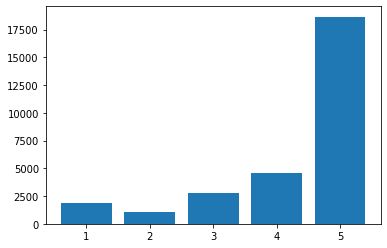

In [11]:
max_num = None # replace lateron
data = balancing(data, balancing = True, max_num = max_num)

Most saved rating is 1 with 1018 datapoints.
Least saved rating is 1 with 1018 datapoints.


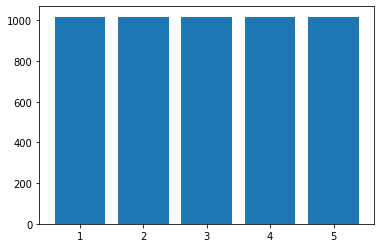

In [12]:
# check balancing
balancing(data, balancing = False, max_num = None)

-------

## Word Vectors

In [13]:
def save_dict_to_json(dic, filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "w")
    json.dump(dic, f)
    f.close()

def load_doc_from_json(filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "w")
    dic = f.read()
    f.close()

In [14]:
# create review_dict
review_dict = create_tf_vector_all_reviews(data)
#save_dict_to_json(review_dict, "review_dict")

# create idf dict
idf_dict = create_idf_dictionary(review_dict)
#save_dict_to_json(idf_dict, "idf_dict")

# create word_vec_dict
word_vec_dict = create_word_vector_dict(review_dict, idf_dict) # speed = 0.2 seconds per datapoint
#np.save('word_vec_dict.npy', word_vec_dict)

# include word_vec_dict in dataframe
data["word_vectors"] = word_vec_dict.values()

In [15]:
# alternative without processing word vectors
#word_vec_dict = np.load('word_vec_dict.npy', allow_pickle=True)[()]
#data["word_vectors"] = word_vec_dict.values()
#data.to_json("data_with_word_vectors")

In [16]:
# get a look at the data
data.head()

,overall,reviewText,word_vectors
0,2,Ok looking card (not great). But I would have ...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,I ordered a bunch of gift cards and when the p...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,I ordered a bunch of gift cards and when the p...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,Don't like the tin - it looks tacky!,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2,I ordered a bunch of gift cards and when the p...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


------

## Train Test Split

In [17]:
# create test and training dataset
test_size = 0.2
train_data, test_data = train_test_split(data,
                                         test_size = test_size,
                                         shuffle=True,
                                         stratify = data["overall"]
                                        )

train_data = train_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

-------

# Now start Sentiment analysis

-------

## knn

In [18]:
# test single n

# init variables
data_point = test_data[:1]
data_point_class = int(data_point["overall"])
data_point = np.asarray(data_point["word_vectors"].to_list())
n = 3

# calc class
calc_class = knn(train_data, data_point, n)

print(f"Test Datapoint has class: {calc_class}")
print(f"Original class was {data_point_class}")

Test Datapoint has class: 3
Original class was 3


In [19]:
# test multiple n

# init variables
data_point = test_data[:1]
data_point_class = int(data_point["overall"])
data_point = np.asarray(data_point["word_vectors"].to_list())
n = [1,2,3,4,5]

# calc class
calc_class = knn(train_data, data_point, n)

print(f"Test Datapoint has class: {calc_class}")
print(f"Original class was {data_point_class}")

Test Datapoint has class: {1: 3, 2: 3, 3: 3, 4: 3, 5: 3}
Original class was 3


In [ ]:
# test accuracy

# get test data
test_vectors = test_data["word_vectors"].to_list()
test_classes = test_data["overall"].to_list()

# init variables
pred_class = []
n_test = list(range(1,30))

# get classes
count = 0
for t_vector in test_vectors:

    pred_class.append(knn(train_data, np.asarray(t_vector), n_test))
    
    count += 1
    if (count % 100) == 0:
        
        print(f"Step {count}")
    
# init accuracy dict
acc_dict = {}

for sub_n in n_test:
    
    sub_n_val_classes = []
    
    for test_el in pred_class:
        
        sub_n_val_classes.append(test_el[sub_n])
    
    # get accuracy of sub_n
    accuracy = accuracy_score(test_classes, sub_n_val_classes)
    acc_dict[sub_n] = accuracy

# visualize
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.show()

----

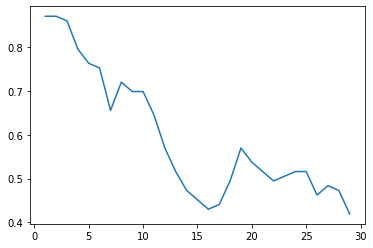

In [98]:
# visualize 
plt.plot(list(evalualtion_dict.keys()), list(evalualtion_dict.values()))
plt.show()

----------

Task: knn in own python file, rewrite to be completly independent of other libs

-------------